Solving track reconstruction
=======================

Up until now, we have created tracks. However, tracks should fulfill some criteria in order to make sense from a physical standpoint: It wouldn't make sense to have several tracks coming from the same hits, or to join random hits together.

Typically one uses known geometrical constraints alongside problem-specific knowledge in order to determine where to look for tracks, and how should tracks look like. Ultimately, there are five quantities one has to look after:


*   Reconstruction Efficiency: The fraction of particles we have reconstructed.
    > \# correctly reconstructed / \# real tracks

*   Clone Tracks: Tracks that are similar to other correctly reconstructed tracks.
    > \# clone tracks / \# correctly reconstructed

*   Fake Tracks: Tracks that are incorrect, either created by noise hits or by incorrectly reconstructing a track.
    > \# incorrectly reconstructed / \# all reconstructed

*   Hit purity: Fraction of hits in a track that belong to the same MC particle.
    > \# track hits in MC particle hits / \# track hits
    
*   Hit efficiency: Number of hits correctly found out of the MC particle hits in a track.
    > \# track hits in MC particle hits / \# MC particle hits

Phew, that was quite a mouthful. If you want one thing to look for at the beginning, that is to *maximize reconstruction efficiency*. First try to reconstruct as much correct as possible, and work out the other indicators one by one.

Alongside the velopix tracking project there are a few algorithms we can try:

In [1]:
# Run this if you didn't run it previously
!git clone https://github.com/dcampora/velopix_tracking.git

fatal: destination path 'velopix_tracking' already exists and is not an empty directory.


In [2]:
import sys, os
sys.path.append(os.getcwd() + "/../")
sys.path.append(os.getcwd() + "/velopix_tracking/")

import json
from event_model import event_model as em

f = open("velopix_tracking/events/velo_event_0.json")
json_data = json.loads(f.read())
event = em.event(json_data)
f.close()

Track following is a technique that reconstructs hits by visiting neighbouring modules. One first creates tracklets or *seeds* and posteriorly follows those tracks until no more hits are found.

<img src="velopix_tracking/doc/reco_example.png" alt="Track follow example" />

Included with the project is a track following implementation. Let's check it out.

In [3]:
from algorithms.track_following import track_following

# Instantiate track following
track_following = track_following()

# Solve the event
tracks = track_following.solve(event)

print("Found %i tracks with track following!" % len(tracks))

Instantiating track_following solver with parameters
 max slopes: (0.7, 0.7)
 max tolerance: (0.4, 0.4)
 max scatter: 0.4

Found 148 tracks with track following!


Track following found tracks, but are these the good tracks? For that, we will need to employ a validator:

In [4]:
from validator import validator_lite as vl
vl.validate_print([json_data], [tracks])

148 tracks including        8 ghosts (  5.4%). Event average   5.4%
              velo :      126 from      134 ( 94.0%,  94.0%)        3 clones (  2.38%), purity: ( 98.83%,  98.83%),  hitEff: ( 93.89%,  93.89%)
              long :       22 from       22 (100.0%, 100.0%)        1 clones (  4.55%), purity: ( 99.52%,  99.52%),  hitEff: ( 93.80%,  93.80%)
         long>5GeV :        8 from        8 (100.0%, 100.0%)        0 clones (  0.00%), purity: (100.00%, 100.00%),  hitEff: (100.00%, 100.00%)


Results are shown for different track categories. Track categories are detector-specific, and refer to different types of tracks depending on the subdetectors they traverse, their energy, the particle decay where they originated from, direction, etc.

<img src="docs/track_types.png" alt="Track follow example" style="width: 600px" />

In the previous case, you can see some tracks are "velo" tracks or "long" tracks, which you can interpret from the image above.

Exercise 2
---------------

Let's first visualize what just happened.

* Use `print_event_2d` to print the event, and then print the event with the tracks found by `track_following`.

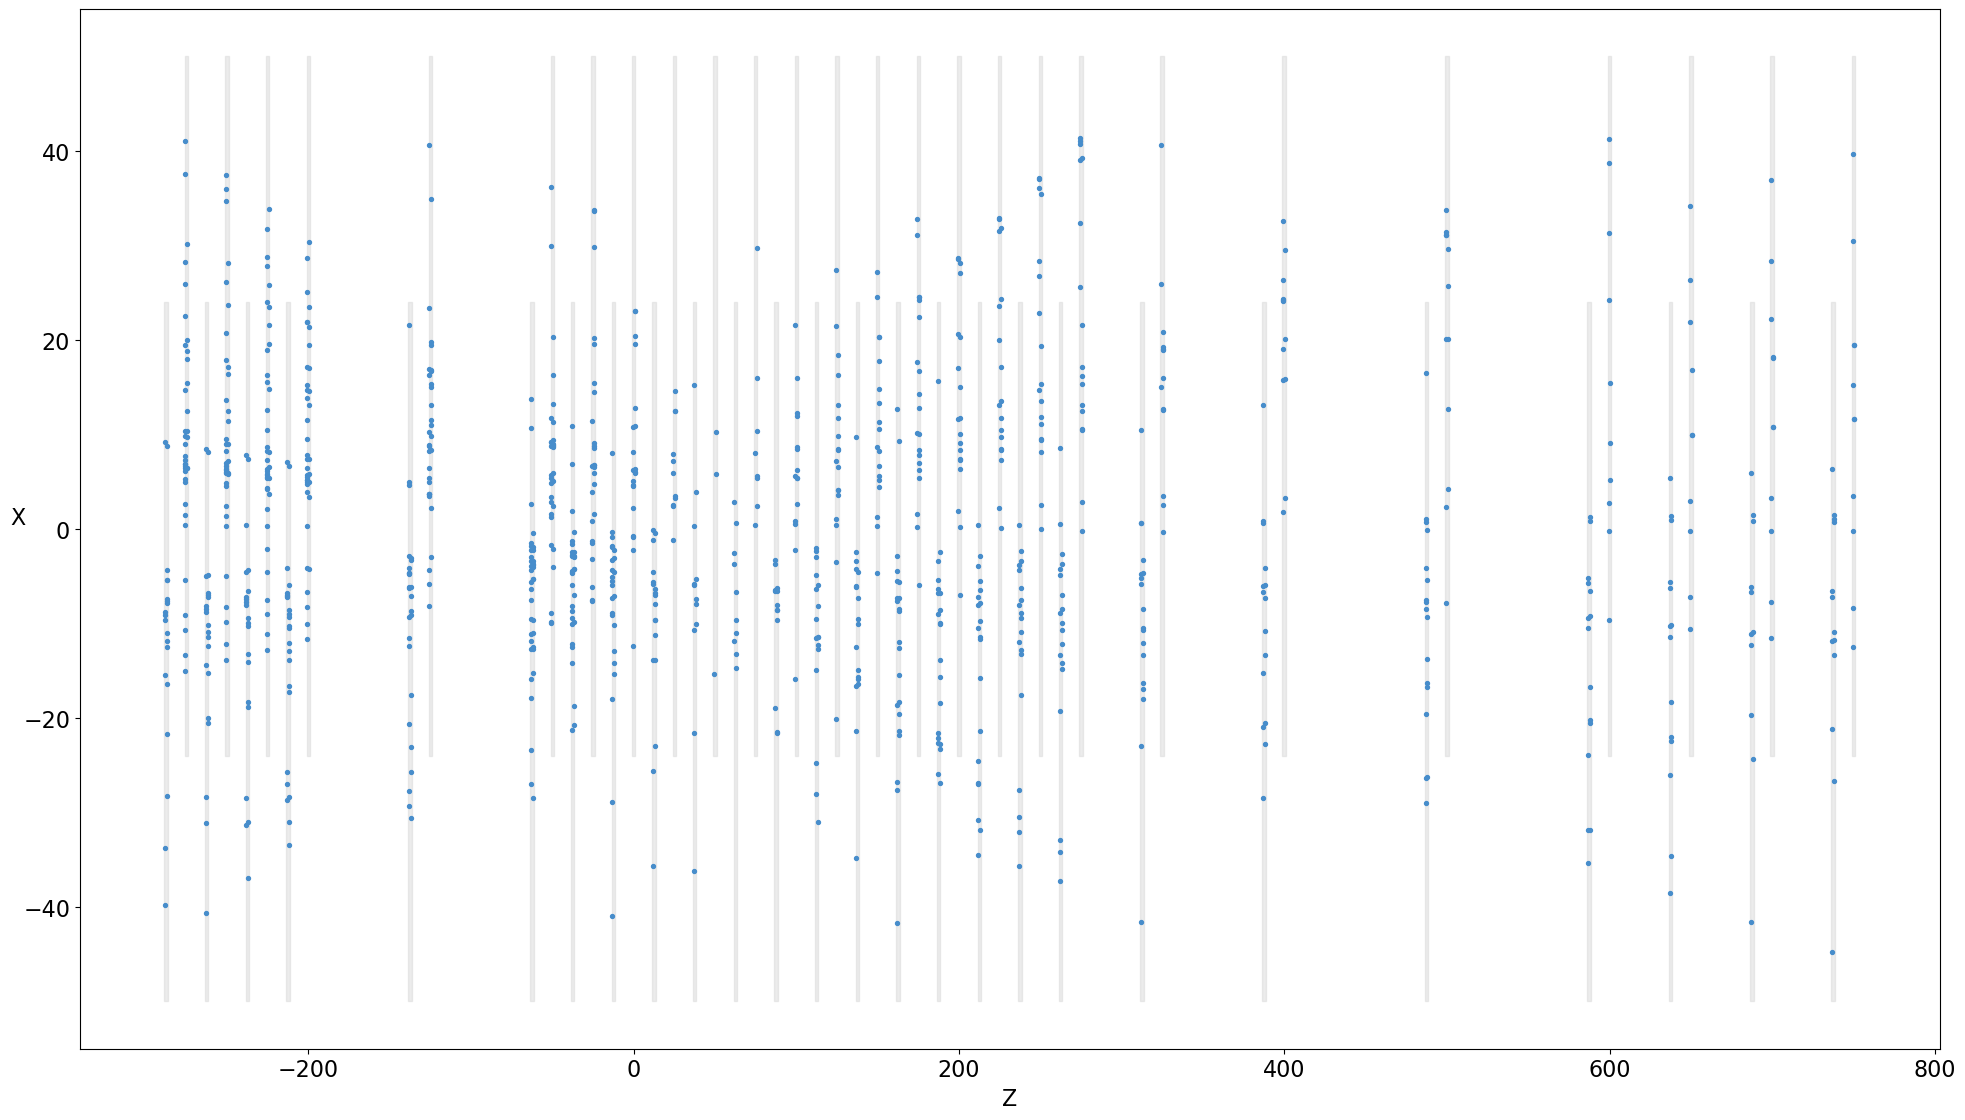

In [12]:
from visual.base import print_event_2d
import matplotlib.pyplot as plt
%matplotlib inline

# Step 1: Print just the event (hits only)
print_event_2d(event)
plt.show()

By plotting the events that have not been tampered with yet, we can visualize the hits from the detectors. These hits are visualized by the points in the above image, which the algorithm will then utilize to find the trajectories of the particles.

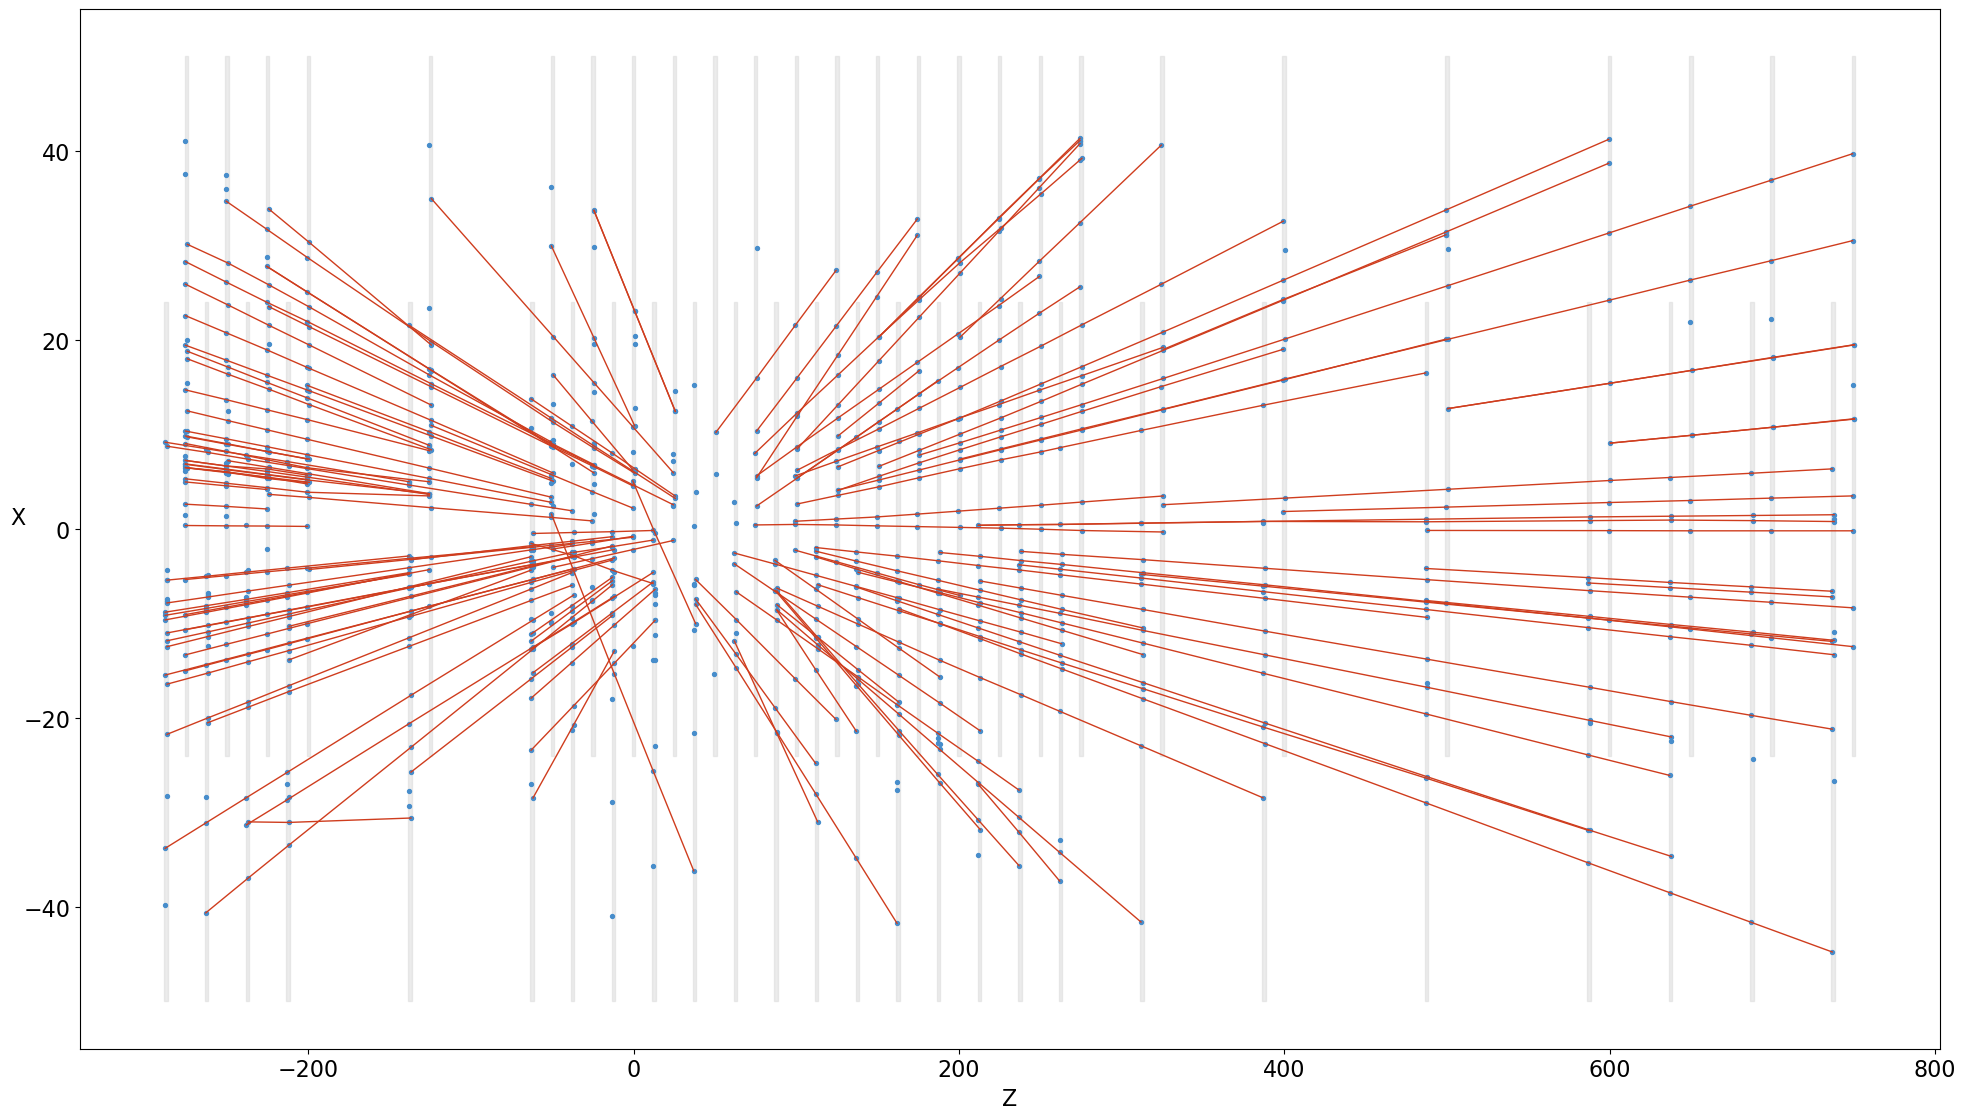

In [13]:
# Step 2: now we visualize the trajectories the algorithm has found,
# overlayed with the events themselves
print_event_2d(event, tracks)
plt.show()

Now we have a visualization of both the events themselves and some of the trajectories of particles that would have likely produced these trajectories, which our algorithm has calculated for us. 
It should be understood that the above plot represents only the Velo detectors, and therefore all the tracks shown have interacted with at least the Velo detectors. By referencing an image that shows the layout of the LHCb detectors (try searching "track types LHCb"), it can be understood that only particles with trajectories relatively parallel to the z-axis (in the plot) and in the positive direction (to the right) will potentially be detected by the other detectors in the LHCb.

* The statistics we have are insufficient. Load iteratively all 10 events and run `track_following` on them. Finally, run the validator once with all the `json` data and all tracks. Do the numbers correspond with the previous ones?

In [14]:
all_json_data = []
all_tracks = []

# 1. We iterate through events 0 -> 9
for i in range(10):
    # mapping the path for each individual events file
    filename = f"velopix_tracking/events/velo_event_{i}.json"

    with open(filename) as f:
        # load the raw json data
        json_data = json.loads(f.read())
        # create an event object that the algorithm understands
        event = em.event(json_data)

        # run track_following on the current event
        tracks = track_following.solve(event)

        # store raw data and results for validator
        all_json_data.append(json_data)
        all_tracks.append(tracks)

# run the validator on the full batch of 10 events
vl.validate_print(all_json_data, all_tracks)

2759 tracks including      273 ghosts (  9.9%). Event average   8.5%
              velo :     2181 from     2377 ( 91.8%,  93.0%)       52 clones (  2.38%), purity: ( 98.07%,  98.20%),  hitEff: ( 94.46%,  94.58%)
              long :      640 from      654 ( 97.9%,  98.5%)       27 clones (  4.22%), purity: ( 98.34%,  98.72%),  hitEff: ( 93.95%,  94.04%)
         long>5GeV :      391 from      401 ( 97.5%,  98.4%)       20 clones (  5.12%), purity: ( 98.10%,  98.68%),  hitEff: ( 94.25%,  93.20%)
      long_strange :       24 from       26 ( 92.3%,  93.7%)        0 clones (  0.00%), purity: ( 97.80%,  96.96%),  hitEff: ( 95.15%,  97.02%)
 long_strange>5GeV :       10 from       11 ( 90.9%,  91.5%)        0 clones (  0.00%), purity: ( 99.00%,  99.33%),  hitEff: ( 94.81%,  95.07%)
        long_fromb :        9 from        9 (100.0%, 100.0%)        0 clones (  0.00%), purity: (100.00%, 100.00%),  hitEff: ( 98.57%,  98.41%)
   long_fromb>5GeV :        4 from        4 (100.0%, 100.0%)       

The ghost rate is indicating about 1 in 10 tracks found dont correspond to any real particles, which we will want to remove in the next analysis.
It is interesting to note that the long track efficiency of this algorithm is actually about 6% more effecient than the Velo track efficiency, which we can understand to potentially mean the track following logic of the algorithm actually works best with particles that have enough momentum to exit the Velo and be detected by the other more distant detectors.

The fake rate is a bit higher than expected. It could be that some of the tracks with less hits are incorrect.

* Remove all tracks with 3 hits and run the validator. Do the results improve? What are the tradeoffs?

In [19]:
cleaned_all_tracks = []

for event_tracks in all_tracks:
    # filter is used to keep tracks where length of hits > 3
    filtered = [t for t in event_tracks if len(t.hits) > 3]
    cleaned_all_tracks.append(filtered)

# run the validator on the newly cleaned data
vl.validate_print(all_json_data, cleaned_all_tracks)


2288 tracks including      121 ghosts (  5.3%). Event average   4.3%
              velo :     1914 from     2377 ( 80.5%,  81.7%)       40 clones (  2.09%), purity: ( 97.79%,  97.98%),  hitEff: ( 94.98%,  94.99%)
              long :      624 from      654 ( 95.4%,  96.8%)       24 clones (  3.85%), purity: ( 98.29%,  98.68%),  hitEff: ( 94.62%,  94.37%)
         long>5GeV :      387 from      401 ( 96.5%,  97.4%)       18 clones (  4.65%), purity: ( 98.07%,  98.66%),  hitEff: ( 95.06%,  93.64%)
      long_strange :       21 from       26 ( 80.8%,  78.0%)        0 clones (  0.00%), purity: ( 97.49%,  96.71%),  hitEff: ( 95.79%,  97.79%)
 long_strange>5GeV :        8 from       11 ( 72.7%,  67.7%)        0 clones (  0.00%), purity: ( 98.75%,  99.00%),  hitEff: ( 96.14%,  96.96%)
        long_fromb :        7 from        9 ( 77.8%,  78.9%)        0 clones (  0.00%), purity: (100.00%, 100.00%),  hitEff: ( 98.21%,  97.96%)
   long_fromb>5GeV :        4 from        4 (100.0%, 100.0%)       

Concise analysis:

Ghost Rate Reduction: Successfully fulfilled the primary goal by eliminating a significant portion of "non-real" trajectories created by random combinatorial noise.
  
   Efficiency Penalty: Observed an ~11% drop in Velo Efficiency because real physical particles that only interacted with 3 modules (the "short track" signal) were discarded along with the ghosts.
  
   Clone Suppression: Achieved a ~10-20% relative reduction in Clone Rates, proving that many duplicate tracks were actually fragments (< 4 hits) of single trajectories.
  
   Purity Dilution: Noted a slight decrease (~0.3% Velo, ~0.05% Long) in Hit Purity. This confirms that while 3-hit tracks are often "perfectly pure," longer tracks are statistically more susceptible to capturing outlier hits as the extrapolation "window" accumulates uncertainty over distance.

Full analysis:

Since filtering tracks with 3 hits out, there is observed a significant reduction in the _ghost rate_, which tells us that many of the short tracks were non real. Therefore, this filtration has fulfilled its main purpose. However, this is not the only affect of incuding this filtration. The Velo reconstruction efficiency also saw a drop, which is the ratio of reconstructed tracks (by the algorithm) to reconstructable MC particles (from the input data recieved from LHCb). This drop of ~11% makes sense since some actual tracks of particles may have only interacted with 3 modules. Therefore, when we get rid of tracks with 3 hits, these real trajectories, not just the ghosts, are also thrown out, leading to a reduction in this %.

Additionally, we see a reduction in clone rates across the board, somewhere around ~10-20% lower relative to the clone rates prior to removing 3 hit tracks. This clones are likely the result of fragmentation of a single real particle track. These fragments are likely very short, (< 4) and therefore are removed with the 3 hit alteration made to the validation.

Lastly, a reduction in the hit purity is observed. This can be explained by the following: the 3-hit tracks that are not ghosts are likely "perfect" tracks, containing hits only from one particle. Inversly, as we deal with longer and longer tracks, the chance of including a hit in the track that was produced by a different particle become higher and higher, which I beleive is likely the result of the algorithm working by taking a 'window' snapshot for potnetial trajectories coming from the previous two hits, and therefore, as you deal with longer tracks, this window continues to increase, making them statistically more and more likely to include invalid hits that were the result of other particels. So, removing the 3-hit tracks removes some of these pure tracks slightly reducing the overall purity, which in this case was ~0.3% decrease for Velo tracks, and ~.05% for Long tracks, which is to be expected from he explanation above.

Exercise 4
---------------

If you still have energy in you, with everything you have learned you have now the tools to attempt creating your own track reconstruction algorithm.

We will first need a function to determine whether a track looks good or bad. One such function is the *means squared error*:

* Create a means_squared_error method that gets a track as an input and calculates the MSE (https://en.wikipedia.org/wiki/Mean_squared_error) of a track.

Now that you have a function to qualify how good a track is *you are in business*. A rough approximation at a tracking in the VELO is as follows:

1. Iterate over 3 modules until you find a *triplet* of hits whose MSE is under a threshold.
2. Extrapolate those hits to the remaining modules until you find no compatible hits with the MSE method in a module.

Implement such a tracking algorithm, and have fun playing around with the data!

In [24]:
import numpy as np

# refining track reconstruction by applying _dynamic_ MSE thresholding and physical angular constraints
def final_refined_algorithm(all_json_data, base_mse=0.001,growth=0.0005,max_angle=0.4):
    final_tracks = []

    for json_data in all_json_data:
        # load event and run the baseline solver to get candidate tracks
        event = em.event(json_data)
        candidates = track_following.solve(event)
        event_refined = []

        for track in candidates:
            num_hits = len(track.hits)
            if num_hits < 3:
                continue # skip tracks that lack enough points for linear fitting

            # calculate exact MSE and slope using _actual_ z-coords
            z_coords = np.array([h.z for h in track.hits])
            x_coords = np.array([h.x for h in track.hits])

            # linear fit for potential tracks: x = m*z + c
            m, c = np.polyfit(z_coords, x_coords, 1)
            predictions = m * z_coords + c
            track_mse = np.mean((x_coords - predictions)**2)

            # apply angular cut (physics cut)
            # this removes non-physical tracks pointing outside the detectors acceptance
            if abs(m) > max_angle:
                continue
        
            # dynamic MSE thresholding (multiple scattering correction)
            # allows the error margin to grow with track length
            allowed_error = base_mse + (num_hits - 3) * growth

            if track_mse < allowed_error:
                event_refined.append(track)

        final_tracks.append(event_refined)

    return final_tracks

# execute the optimized reconstruction on the 10-event dataset
optimized_results = final_refined_algorithm(all_json_data)

# run the final validation to see the performance improvements
vl.validate_print(all_json_data, optimized_results)

2144 tracks including       61 ghosts (  2.8%). Event average   2.1%
              velo :     1924 from     2377 ( 80.9%,  82.8%)       22 clones (  1.14%), purity: ( 99.04%,  99.00%),  hitEff: ( 95.30%,  95.62%)
              long :      592 from      654 ( 90.5%,  89.8%)       15 clones (  2.53%), purity: ( 99.19%,  99.36%),  hitEff: ( 94.70%,  95.26%)
         long>5GeV :      371 from      401 ( 92.5%,  93.9%)        9 clones (  2.43%), purity: ( 99.10%,  99.42%),  hitEff: ( 95.61%,  95.07%)
      long_strange :       20 from       26 ( 76.9%,  75.0%)        0 clones (  0.00%), purity: ( 99.74%,  99.56%),  hitEff: ( 97.77%,  98.04%)
 long_strange>5GeV :        9 from       11 ( 81.8%,  76.3%)        0 clones (  0.00%), purity: (100.00%, 100.00%),  hitEff: ( 94.64%,  95.63%)
        long_fromb :        8 from        9 ( 88.9%,  84.4%)        0 clones (  0.00%), purity: (100.00%, 100.00%),  hitEff: ( 98.21%,  98.21%)
   long_fromb>5GeV :        4 from        4 (100.0%, 100.0%)       

Final analysis:

The final algorithm dropped the ghost rate from 9.9% to 2.8%. The 3-hit filter helped, but the Dynamic MSE was what really worked. It checked if tracks were actually straight lines, which removed random noise that the simple hit-counter didn't catch.

Velo efficiency dropped by about 11% after Exercise 3 and stayed flat. This shows that around 10% of real tracks only have 3 hits. To get rid of ghosts, I had to set a minimum hit limit, which means I chose to lose those short real tracks to get a cleaner result.

Purity went down a bit in Exercise 3 but went up to 99.04% in the final version. Using the Angular Cut and the MSE check together made sure the tracks were straight and pointing the right way. This removed "outlier hits" that were being accidentally added to longer tracks.


Final conclusion for the 3 iterations:

The baseline had too many ghosts (9.9%), and the 3-hit filter was just a start. The final version is the best because it got ghosts down to 2.8% and purity up to nearly 100%. It shows that checking how straight a track is (MSE) is better than just counting how many hits it has.